## Import libraries

In [40]:
import pandas as pd
import numpy as np

import os

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import utils

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Reading feature dataset

In [47]:
data_file = '../data/processed/cluster_features'
df_dataset = utils.read_pickles(data_file)
order_ids = df_dataset.pop('order_id')

100%|██████████| 3/3 [00:00<00:00, 34.48it/s]


## PCA
* To see if we can see any visual clusters

In [4]:
pca = PCA(n_components=2)
pca.fit(df_dataset.values)
data_pca = pca.transform(df_dataset.values)

## Plot pca transformed data

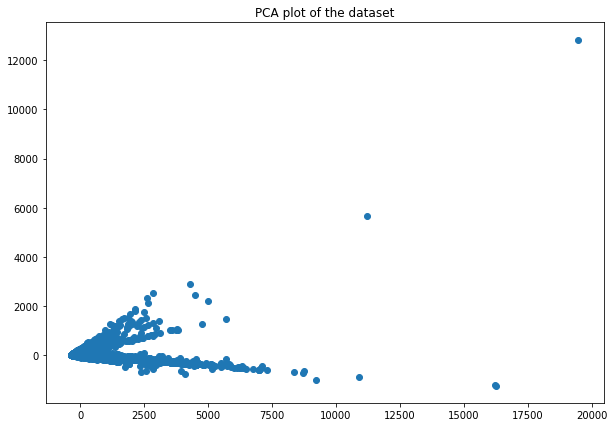

In [114]:
plt.figure(figsize=(10,7))
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.title('PCA plot of the dataset')
plt.show()

## Hirarchial clustering on dataset
* memory error, picked top 20k orders

In [13]:
model = AgglomerativeClustering(n_clusters=2, linkage='single')
predicted = model.fit_predict(data_pca[:20000])

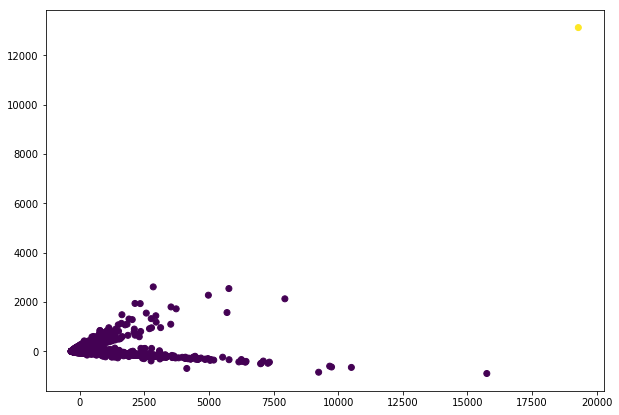

In [17]:
plt.figure(figsize=(10,7))
plt.title('Cluster plot of the dataset')
plt.scatter(data_pca[:20000, 0], data_pca[:20000, 1], c=predicted)
plt.show()

### Note: unsuccessful attempt to cluster

In [19]:
np.unique(predicted, return_counts=True)

(array([0, 1], dtype=int64), array([19999,     1], dtype=int64))

## Cluster orders with reviews only

In [22]:
pca = PCA(n_components=2)
pca.fit(df_dataset[df_dataset['review_comment_words']>0].values)
data_pca = pca.transform(df_dataset[df_dataset['review_comment_words']>0].values)

In [23]:
model = AgglomerativeClustering(n_clusters=2, linkage='ward')
predicted = model.fit_predict(data_pca)

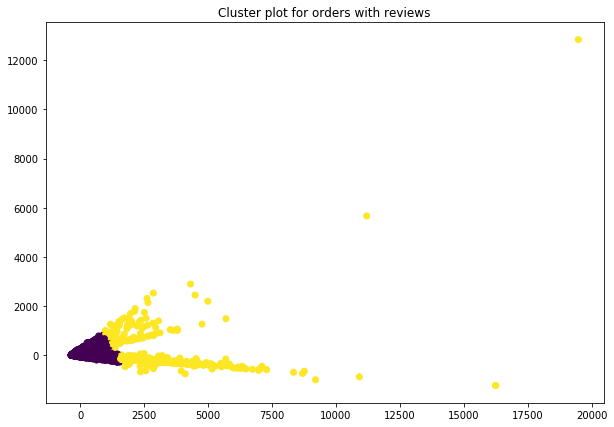

In [115]:
plt.figure(figsize=(10,7))
plt.title('Cluster plot for orders with reviews')
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=predicted)
plt.show()

## Average reviews/items/value per cluster

In [30]:
df_cluster = df_dataset[df_dataset['review_comment_words']>0]
df_cluster['cluster'] = predicted

In [36]:
aggs = {
       'review_score':'mean',
       'review_comment_words': 'mean',
       'order_items_counts':'mean',
       'price_sum':'mean',
       'freight_sum':'mean'}

df_analysis = df_cluster.groupby('cluster').agg(aggs)

In [37]:
df_analysis

,review_score,review_comment_words,order_items_counts,price_sum,freight_sum
cluster,,,,,
0,3.750257,11.621402,1.174805,122.772142,23.178146
1,3.551122,13.778055,1.512469,1296.345848,75.563030


## Tackling memory issue
    * Treated Clustering as predictive problem, 
    * Used Agglomerative to fit on orders with reviews
    * Predicted on orders without reviews.

In [41]:
KN = KNeighborsClassifier(n_neighbors=10)
KN.fit(df_cluster[df_cluster.columns[:-1]], predicted)
no_review_labels = KN.predict(df_dataset[df_dataset['review_comment_words']==0])

In [42]:
df_no_review = df_dataset[df_dataset['review_comment_words']==0]
df_no_review['cluster'] = no_review_labels

In [43]:
df_analysis_no_review = df_no_review.groupby('cluster').agg(aggs)
df_analysis_no_review

,review_score,review_comment_words,order_items_counts,price_sum,freight_sum
cluster,,,,,
0,4.416838,0,1.11191,113.473407,21.124865
1,4.414129,0,1.36419,1284.568745,66.310183


## Mapping clustters to states

In [59]:
df_customers = utils.read_pickles('../data/processed/customers')

import pickle
with open('../data/processed/cust_state.pickle', 'rb') as f:
    cust_state = pickle.load(f)
    
df_customers['customer_state'] = df_customers['customer_state'].astype('category').map(cust_state)

100%|██████████| 3/3 [00:00<00:00, 25.64it/s]


## Create df to store clusters and states

In [66]:
df_mapcluster = pd.DataFrame()

df_mapcluster['order_id'] = order_ids
df_mapcluster['cluster'] = float('inf')

df_mapcluster.loc[df_dataset[df_dataset['review_comment_words']>0].index, 'cluster'] = predicted
df_mapcluster.loc[df_dataset[df_dataset['review_comment_words']==0].index,'cluster'] = no_review_labels

df_mapcluster = df_mapcluster.merge(df_customers[['customer_state', 'order_id']], on='order_id')

df_state_cluster = df_mapcluster.groupby(['cluster', 'customer_state']).count().reset_index()

df_state_cluster.sort_values(['cluster', 'order_id'], ascending=[True, False], inplace=True)

## Top 10 states with cluster 0.0 and 1.0

In [112]:
df_state_cluster[df_state_cluster['cluster']==0.0][['customer_state','order_id']].head(10)

,customer_state,order_id
25,SP,40187
18,RJ,12196
10,MG,11227
22,RS,5293
17,PR,4862
23,SC,3498
4,BA,3200
6,DF,2062
7,ES,1977
8,GO,1940


In [113]:
df_state_cluster[df_state_cluster['cluster']==1.0][['customer_state','order_id']].head(10)

,customer_state,order_id
52,SP,514
45,RJ,222
37,MG,193
49,RS,87
44,PR,80
31,BA,74
50,SC,62
40,PA,39
33,DF,37
32,CE,35
